### Introduction

This notebook details the process of using NLP, Machine Learning and Deep Learning to classify tweets from congress as right or left leaning. The goal is to explore if a model can detect political bias in tweets.

Sources for the data include:

- Twitter (using the Twint Twitter scraper tool)
- TriageCancer.org
- The Stanford NLP Group

### Webscraping

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import time
from bs4 import BeautifulSoup
import twint
import nest_asyncio
nest_asyncio.apply()

We will begin by using the BeautifulSoup library to scrape congressional social media handles from a TriageCancer.org. This will eventually allow us to scrape twitter for tweets from members of congress.

In [ ]:
url = "https://triagecancer.org/congressional-social-media"
soup = BeautifulSoup(requests.get(url).text)

In [ ]:
containers = [soup.findAll('tr', {"class": f"ninja_table_row_{num}"}) for num in range(541)]

In [ ]:
names = [c[0].findAll("td")[2].text for c in containers]

In [ ]:
parties = [c[0].findAll("td")[4].text for c in containers]

In [ ]:
handles = [c[0].findAll("td")[5].text for c in containers]

Combining the names of congress members, their respective parties, and twitter handles into a dataframe.

In [ ]:
twitter_df = pd.DataFrame(columns = ["name", "party", "t_handle"])
twitter_df["name"] = names
twitter_df["party"] = parties
twitter_df["t_handle"] = handles

In [ ]:
twitter_df["t_handle"] = twitter_df["t_handle"].map(lambda x: x.strip("@"))

Adding additional names and twitter handles of prominent political figures to the dataframe.

In [ ]:
add_names = ["Biden, Joe", "Clinton, Hillary", "Obama, Barack", "Pence, Mike", "Pompeo, Mike"]
add_parties = ["D", "D", "D", "R", "R"]
add_handles = ["JoeBiden", "HillaryClinton", "BarackObama", "Mike_Pence", "mikepompeo"]
d = {'name': add_names, 'party': add_parties, 't_handle': add_handles}
add_df = pd.DataFrame(data=d)

In [ ]:
twitter_df = twitter_df.append(add_df)

Splitting the dataframe into more popular politicians and less, since we will use different parameters for each group.

In [ ]:
most_popular = twitter_df[twitter_df["t_handle"].isin(["HillaryClinton", "JoeBiden", 
                                                   "BarackObama", "SenSanders",
                                                  "Mike_Pence","KamalaHarris"])]

In [ ]:
less_popular = twitter_df[~twitter_df["t_handle"].isin(["HillaryClinton", "JoeBiden", 
                                                   "BarackObama", "SenSanders",
                                                  "Mike_Pence","KamalaHarris"])]

### Extracting Data from Twint

We will now scrape twitter for tweets from congress members. To do this we will use the twitter scraper tool, Twint, that streamlines the scraping process without the use of the Twitter API.

To begin, we will develop some functions that will configure the tool and set some filtering parameters to scrape tweets.

In [ ]:
def extract_twint(user, since, min_likes):
    c = twint.Config()
    c.Username = user
    c.Since = since
    c.Lang = "en"
    c.Min_likes = min_likes
    c.Popular_tweets = True
    c.Pandas = True
    c.Hide_output = True
    twint.run.Search(c)
    df = twint.storage.panda.Tweets_df
    return df

In [ ]:
def extract_all(df, since, min_likes):
    users = list(df["t_handle"])
    data = pd.DataFrame([])
    for u in users:
        try:
            u_df = extract_twint(u, since, min_likes)
            data = data.append(u_df)
        except ValueError:
            continue
    return data

For the less popular tweeters, we will set a minimum of 50 likes per tweet, while for the more popular tweeters, we will set a minimum threshold of 500 likes. We will extract all tweets from members of congress from january 2016 - February 2021.

In [ ]:
tweets_less = extract_all(less_popular,'2016-01-01', 50)

In [ ]:
tweets_more = extract_all(most_popular,'2016-01-01', 500)

We will now combine all the tweets into a dataframe and filter the tweets by language and relevant features.

In [ ]:
tweets_less = tweets_less[tweets_less["language"] == "en"]

In [ ]:
tweets_all = tweets_less.append(tweets_more)

In [ ]:
tweets_all = tweets_all[tweets_all["language"] == "en"]

In [ ]:
tweets_all = tweets_all[["id", "date", "tweet", "language", "username", "nlikes", "hashtags"]]

In [ ]:
tweets_all["characters"] = tweets_all["tweet"].map(lambda x: len(x))

Exporting tweets to csv to avoid having to continuously scrape twint every time we run the notebook.

In [ ]:
tweets_all.to_csv("Data/tweets_all.csv")

In [28]:
tweets_all = pd.read_csv("Data/tweets_all.csv")

In [29]:
tweets_all.drop(columns = "Unnamed: 0", inplace=True)

In [ ]:
twitter_df.rename(columns={"t_handle": "username"}, inplace=True)

Joining the twitter dataframe with congress members names, twitter handles, and political party to the tweets dataframe based on twitter handle (username).

In [ ]:
expanded_df = tweets_all.join(twitter_df.set_index("username"), on="username", how="left")

Cleaning the dataframe by dropping duplicates, changing datatypes, filtering and rearranging columns.

In [ ]:
cols = ['id', 'name', 'username', 'date', 'tweet', 'characters', 'language', 'nlikes', 'hashtags','party']
expanded_df = expanded_df[cols]

In [ ]:
expanded_df = expanded_df[expanded_df["characters"] > 50]

In [ ]:
expanded_df["date"] = pd.to_datetime(expanded_df["date"])

In [ ]:
expanded_df.drop_duplicates(subset="id", inplace=True)

In [ ]:
expanded_df.head()

Since there are tweets from only two independent politicians, we will either drop them or label them as republican or democrat. We will drop Angus King, but label Bernie Sanders as "D", due to him running under the democratic party during the 2020 election.

In [5]:
expanded_df.drop(expanded_df[expanded_df['name'] == "Angus King"].index, inplace = True)

In [6]:
expanded_df.loc[(expanded_df["name"] == 'Sanders, Bernie'),"party"]="D"

We will now check for Nan values

In [7]:
expanded_df.isna().sum()

id                0
name          22491
username          0
date              0
tweet             0
characters        0
language          0
nlikes            0
hashtags          0
party         22491
dtype: int64

In [8]:
expanded_df.loc[(expanded_df["party"] != 'R')&(expanded_df["party"] != 'D')]["username"].value_counts()[:50]

justinamash        3267
SenatorTomUdall    2411
mattgaetz          2018
RepDougCollins     1589
DougJones          1277
TulsiPress         1159
SteveKingIA        1011
RepDavids           803
SenCoryGardner      793
RepCunningham       636
sendavidperdue      625
RepDMP              598
SenatorLoeffler     579
repjohnlewis        526
HurdOnTheHill       514
RepHarley           441
RepMarkWalker       414
RepRiggleman        398
SenAlexander        326
braun4indiana       291
RepPeteKing         281
RepEliotEngel       243
RepTedYoho          199
RepByrne            163
NitaLowey           122
RepTorresSmall      118
LacyClayMO1         104
RepMaxRose          103
andybiggs4az        102
JimLangevin          89
SenPatRoberts        80
RepRossSpano         73
repgregwalden        73
RepAbraham           73
RepKirkpatrick       73
RepGilCisneros       70
jamie_raskin         66
RepBrindisi          62
RepJoseSerrano       60
SusanWBrooks         59
RepFinkenauer        58
RepMikeRogersAL 

To preserve data, we will manually label the politicians that did not have a party listed on the Triage Cancer website.

In [9]:
expanded_df.loc[(expanded_df["username"] == 'SenatorTomUdall'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'SenatorTomUdall'),"name"]="Udall, Tom"

In [10]:
expanded_df.loc[(expanded_df["username"] == 'mattgaetz'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'mattgaetz'),"name"]="Gaetz, Matt"

In [11]:
expanded_df.loc[(expanded_df["username"] == 'RepDougCollins'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'RepDougCollins'),"name"]="Collins, Doug"

In [12]:
expanded_df.loc[(expanded_df["username"] == 'DougJones'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'DougJones'),"name"]="Jones, Doug"

In [13]:
expanded_df.loc[(expanded_df["username"] == 'TulsiPress'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'TulsiPress'),"name"]="Gabbard, Tulsi"

In [14]:
expanded_df.loc[(expanded_df["username"] == 'SteveKingIA'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'SteveKingIA'),"name"]="King, Steve"

In [15]:
expanded_df.loc[(expanded_df["username"] == 'RepDavids'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'RepDavids'),"name"]="Davids, Sharice"

In [16]:
expanded_df.loc[(expanded_df["username"] == 'SenCoryGardner'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'SenCoryGardner'),"name"]="Gardner, Cory"

In [17]:
expanded_df.loc[(expanded_df["username"] == 'RepCunningham'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'RepCunningham'),"name"]="Cunningham, Joe"

In [18]:
expanded_df.loc[(expanded_df["username"] == 'sendavidperdue'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'sendavidperdue'),"name"]="Perdue, David"

In [19]:
expanded_df.loc[(expanded_df["username"] == 'RepDMP'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'RepDMP'),"name"]="Mucarsel-Powell, Debbie"

In [20]:
expanded_df.loc[(expanded_df["username"] == 'SenatorLoeffler'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'SenatorLoeffler'),"name"]="Loeffler, Kelly"

In [21]:
expanded_df.loc[(expanded_df["username"] == 'repjohnlewis'),"party"]="D"
expanded_df.loc[(expanded_df["username"] == 'repjohnlewis'),"name"]="Lewis, John"

In [22]:
expanded_df.loc[(expanded_df["username"] == 'HurdOnTheHill'),"party"]="R"
expanded_df.loc[(expanded_df["username"] == 'HurdOnTheHill'),"name"]="Hurd, Will"

In [23]:
expanded_df.dropna(inplace=True)

### Data Preprocessing and EDA

When working with text data, there are various techiques that can be employed to preprocess it. Some of these include:

- Tokenization: splitting text into individual "tokens" (words or symbols based on a predefined pattern)
- Removing punctuation and capitalization
- Stopword removal: removal of words that are considered irrevelant (ex: and, you, it, have, etc.)
- Lemmatization: Condensing words down to their "lemma" (ex: running - run)
    
We will use the NLTK library to perform these preprocessing steps.

In [81]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from  nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import re
import preprocessor as p
import spacy
nlp = spacy.load("en_core_web_sm")
from wordcloud import WordCloud, ImageColorGenerator
import gensim
from gensim.utils import simple_preprocess

Defining a regex pattern to tokenize the data and also a stopwords list.

In [82]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
stopwords_list = stopwords.words("english")

We will add some additional words and characters to the stopwords list based on previous results.

In [83]:
stopwords_list.append("&amp")
stopwords_list.append("amp")
stopwords_list.append("ca")
stopwords_list.append("nt")
stopwords_list.append("s")
stopwords_list.append("'s")
stopwords_list.append("ve")
stopwords_list.append("w")
stopwords_list.append("u")
stopwords_list.append("be")

Defining some functions to perform the text preprocessing steps.

In [84]:
def process_text(text, pattern):
    text = p.clean(text)
    raw = nltk.regexp_tokenize(text, pattern)
    lower_tokens = [w.lower() for w in raw]
    words_stopped = [w for w in lower_tokens if w not in stopwords_list]
    separator = ' '
    sentence = separator.join(words_stopped)
    return sentence

In [85]:
def lemmatize(text):
    w_ls = []
    for word in nlp(text):
        w_ls.append(word.lemma_)
    words_stopped = [w for w in w_ls if w not in stopwords_list]
    separator = ' '
    sentence = separator.join(words_stopped)
    return sentence

Creating a new dataframe to store the preprocessed tweets. 

In [29]:
preprocess = expanded_df.copy()

In [30]:
preprocess["tokens"] = preprocess["tweet"].map(lambda x: process_text(x, pattern))

In [31]:
preprocess["lemmatized"] = preprocess["tokens"].map(lambda x: lemmatize(x))

In [32]:
preprocess.head()

,id,name,username,date,tweet,characters,language,nlikes,hashtags,party,tokens,lemmatized
0,1358826533310390272,"Shelby, Richard",SenShelby,2021-02-08 11:14:25,"Although I plan to retire, I am not leaving to...",270,en,154,[],R,although plan retire leaving today two good ye...,although plan retire leave today two good year...
1,1358826532450541573,"Shelby, Richard",SenShelby,2021-02-08 11:14:25,Today I announce that I will not seek a sevent...,232,en,617,[],R,today announce seek seventh term senate everyt...,today announce seek seventh term senate everyt...
2,1358538474639544321,"Shelby, Richard",SenShelby,2021-02-07 16:09:47,George Shultz was a great statesman. He held f...,206,en,112,[],R,george shultz great statesman held four cabine...,george shultz great statesman hold four cabine...
3,1357132614071689217,"Shelby, Richard",SenShelby,2021-02-03 19:03:24,"Congratulations to Ann Berry, the new Secretar...",275,en,220,[],R,congratulations ann berry new secretary senate...,congratulation ann berry new secretary senate ...
4,1357059443435991046,"Shelby, Richard",SenShelby,2021-02-03 14:12:38,"Cosponsored a resolution, which just passed in...",279,en,144,[],R,cosponsored resolution passed senate honoring ...,cosponsor resolution pass senate honor life le...


In [37]:
preprocess["lemmatized"].str.split(expand=True).stack().value_counts()[:50]

trump         53769
american      53418
today         40148
president     39675
people        37988
need          37478
make          36010
work          35478
must          32322
I             31637
family        29867
get           28304
right         27389
time          27217
vote          27154
health        25121
year          24776
one           24275
day           24197
bill          23968
act           23521
country       23009
fight         23001
congress      22873
care          22827
take          22709
senate        22576
house         22149
state         21270
help          21021
go            19712
republican    19634
pass          19587
would         19343
support       19199
protect       18569
thank         17941
new           17699
america       17648
woman         17335
say           16521
community     16447
know          16393
like          16123
keep          16042
call          16036
law           15978
every         15741
continue      15623
million       15590


We will check for and drop Nan values from the tokenized and lemmatized tweets.

In [60]:
preprocess.dropna(inplace = True)

Exporting the preprocessed dataframe to a csv to avoid repeatedly running code every time the notebook is opened.

In [61]:
preprocess.to_csv("Data/preprocess.csv", index=False)

In [4]:
preprocess = pd.read_csv("Data/preprocess.csv")

Creating a dataframe specifically for EDA purposes and splitting the dataframe by political party ("R" and "D" classes), as the political party of the tweeter will serve the labels for our data.

In [5]:
eda = preprocess.copy()

In [6]:
right = eda[eda["party"] == "R"]
left = eda[eda["party"] == "D"]

In [66]:
right.describe()

,id,characters,nlikes
count,9.857100e+04,98571.000000,98571.000000
mean,1.135182e+18,195.346380,2227.821377
std,1.690822e+17,72.691264,6572.643177
min,6.829092e+17,51.000000,0.000000
25%,1.023600e+18,135.000000,152.000000
50%,1.185216e+18,197.000000,377.000000
75%,1.269321e+18,267.000000,1432.000000
max,1.359657e+18,500.000000,227274.000000


In [67]:
left.describe()

,id,characters,nlikes
count,3.034470e+05,303447.000000,3.034470e+05
mean,1.077435e+18,198.673409,4.572446e+03
std,1.772615e+17,68.966159,3.151070e+04
min,6.828041e+17,51.000000,1.200000e+01
25%,9.258824e+17,139.000000,1.390000e+02
50%,1.091530e+18,198.000000,3.400000e+02
75%,1.233545e+18,267.000000,1.531000e+03
max,1.359659e+18,777.000000,4.281004e+06


Looking at the descriptive statistics for the two classes, both has similar average character length of tweets (195 vs 198), but left leaning politicians recieved significantly more likes on average. 

In [68]:
left["nlikes"].median(), right["nlikes"].median()

(340.0, 377.0)

However, the medians in terms of likes were much more similar.

We will now look at the most common words per class.

In [69]:
right["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:10]

american     0.008582
today        0.006570
work         0.005386
president    0.005186
people       0.005134
time         0.004446
need         0.004402
make         0.004278
great        0.004241
vote         0.004052
dtype: float64

In [70]:
left["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:10]

trump        0.010182
american     0.008277
president    0.006524
need         0.006320
people       0.006193
today        0.006183
make         0.006057
must         0.005694
work         0.005596
I            0.005356
dtype: float64

The most common 10 words in each class are fairly similar, albeit in slightly different proportions. The most commonly used word in left leaning tweets was "Trump" while in right leaning it was "american".

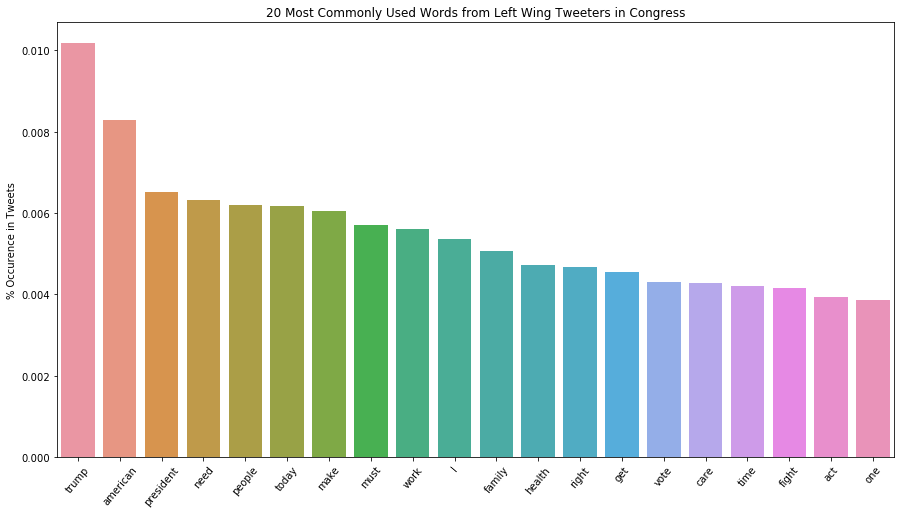

In [71]:
plt.figure(figsize=(15,8))
sns.barplot(x=left["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].index,
            y=left["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].values)
plt.title("20 Most Commonly Used Words from Left Wing Tweeters in Congress")
plt.ylabel("% Occurence in Tweets")
plt.xticks(rotation=50)
plt.show()

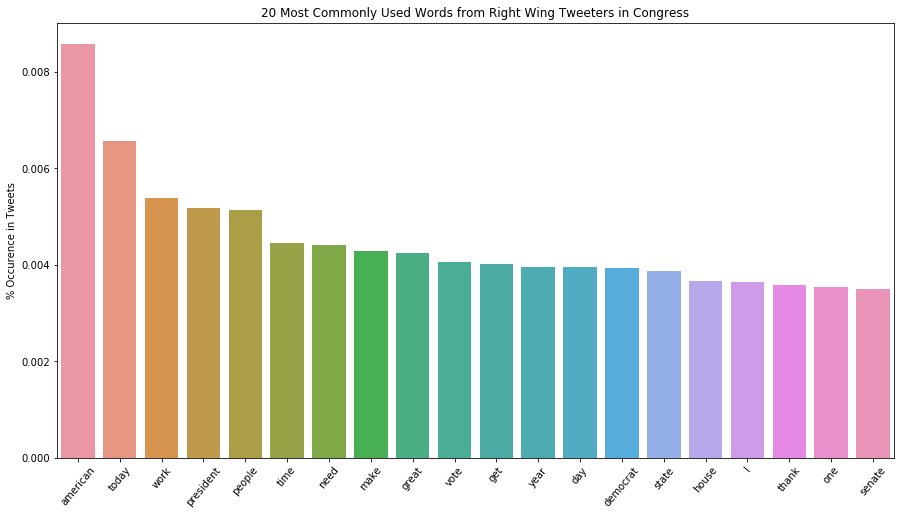

In [72]:
plt.figure(figsize=(15,8))
sns.barplot(x=right["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].index,
            y=right["lemmatized"].str.split(expand=True).stack().value_counts(normalize=True)[:20].values)
plt.title("20 Most Commonly Used Words from Right Wing Tweeters in Congress")
plt.ylabel("% Occurence in Tweets")
plt.xticks(rotation=50)
plt.show()

Another way to visualize the most commonly used words for each class is through word clouds, where the more commonly used words are represented in bigger text.

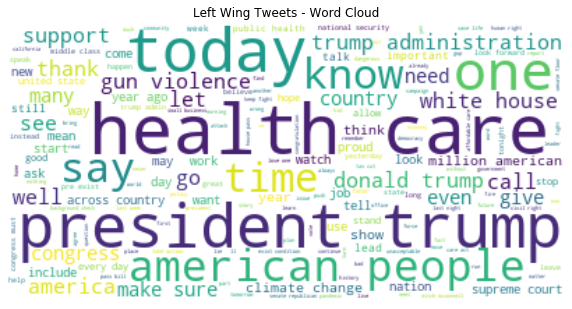

In [74]:
plt.figure(figsize=(10, 8))
left_text = " ".join(tweet for tweet in left["lemmatized"])
wordcloud_l = WordCloud(background_color="white").generate(left_text)
plt.imshow(wordcloud_l, interpolation='bilinear')
plt.axis("off")
plt.title("Left Wing Tweets - Word Cloud")
plt.show()

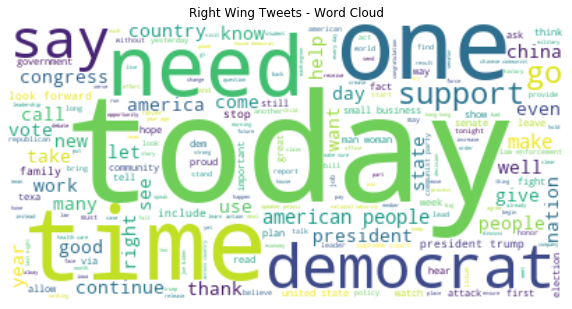

In [75]:
plt.figure(figsize=(10, 8))
right_text = " ".join(tweet for tweet in right["lemmatized"])
wordcloud_r = WordCloud(background_color="white").generate(right_text)
plt.imshow(wordcloud_r, interpolation='bilinear')
plt.axis("off")
plt.title("Right Wing Tweets - Word Cloud")
plt.show()

We will now perform LDA (latent dirichlet allocation) to form topic clusters out of the words in each class.

In [76]:
def list_tokens_lemmas(df, col):
    tokens_list = []
    for sentence in df[col]:
        word_list = []
        for word in sentence.split(" "):
            word_list.append(word)
        tokens_list.append(word_list)
    return tokens_list

In [77]:
left_tokens = list_tokens_lemmas(left, "lemmatized")
right_tokens = list_tokens_lemmas(right, "lemmatized")

In [78]:
left_dict = gensim.corpora.Dictionary(left_tokens)
right_dict = gensim.corpora.Dictionary(right_tokens)

In [79]:
left_dict.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
right_dict.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [80]:
left_corpus = [left_dict.doc2bow(text) for text in left_tokens]
right_corpus = [right_dict.doc2bow(text) for text in right_tokens]

In [81]:
left_lda =  gensim.models.LdaMulticore(left_corpus, 
                                   num_topics = 5, 
                                   id2word = left_dict,                                    
                                   passes = 10,
                                   workers = 2)
left_lda.print_topics()

[(0,
  '0.016*"pay" + 0.011*"worker" + 0.011*"tax" + 0.011*"work" + 0.010*"make" + 0.009*"job" + 0.009*"climate" + 0.009*"family" + 0.008*"need" + 0.008*"cut"'),
 (1,
  '0.016*"vote" + 0.014*"I" + 0.013*"get" + 0.013*"make" + 0.012*"today" + 0.011*"day" + 0.009*"gun" + 0.008*"go" + 0.008*"time" + 0.008*"work"'),
 (2,
  '0.014*"woman" + 0.013*"country" + 0.011*"right" + 0.011*"today" + 0.010*"fight" + 0.010*"year" + 0.009*"nation" + 0.009*"family" + 0.009*"america" + 0.009*"stand"'),
 (3,
  '0.030*"health" + 0.029*"care" + 0.015*"need" + 0.012*"act" + 0.011*"people" + 0.011*"million" + 0.011*"right" + 0.010*"must" + 0.010*"family" + 0.009*"bill"'),
 (4,
  '0.028*"president" + 0.010*"donald" + 0.008*"must" + 0.007*"election" + 0.007*"people" + 0.007*"republican" + 0.007*"say" + 0.006*"congress" + 0.006*"house" + 0.006*"hillary"')]

Some of the topic clusters for left leaning tweets may be related to elections, healthcare, legislation, work and taxes.

In [82]:
right_lda =  gensim.models.LdaMulticore(right_corpus, 
                                   num_topics = 5, 
                                   id2word = right_dict,                                    
                                   passes = 10,
                                   workers = 2)
right_lda.print_topics()

[(0,
  '0.015*"today" + 0.013*"president" + 0.013*"year" + 0.013*"day" + 0.012*"great" + 0.012*"thank" + 0.012*"america" + 0.011*"life" + 0.011*"nation" + 0.011*"honor"'),
 (1,
  '0.013*"border" + 0.011*"china" + 0.011*"act" + 0.010*"security" + 0.009*"must" + 0.008*"support" + 0.007*"bill" + 0.007*"law" + 0.007*"protect" + 0.007*"right"'),
 (2,
  '0.018*"great" + 0.017*"today" + 0.016*"join" + 0.011*"discuss" + 0.010*"thank" + 0.009*"morning" + 0.009*"texas" + 0.009*"watch" + 0.009*"tonight" + 0.009*"I"'),
 (3,
  '0.015*"vote" + 0.014*"democrat" + 0.012*"president" + 0.011*"house" + 0.009*"election" + 0.009*"people" + 0.008*"impeachment" + 0.008*"say" + 0.008*"senate" + 0.007*"trump"'),
 (4,
  '0.015*"job" + 0.014*"work" + 0.012*"need" + 0.009*"business" + 0.009*"get" + 0.008*"help" + 0.008*"people" + 0.008*"economy" + 0.007*"america" + 0.007*"year"')]

Some topic clusters for right leaning tweets may include elections, national security, international relations and the economy.

We will now investigate the top and most frequent tweeters from both classes

In [235]:
print("Some of the most frequent tweeters in the last five years from the right side include: \n")
for name in right["name"].value_counts()[:5].index:
    print(name)
print("\nAccounting for a total of {} tweets".format(right["name"].value_counts()[:5].sum()))

Some of the most frequent tweeters in the last five years from the right side include: 

Rubio, Marco
Cruz, Ted
Cornyn, John
Paul, Rand
Blackburn, Marsha

Accounting for a total of 28027 tweets


In [236]:
print("Some of the most frequent tweeters in the last five years from the left side include: \n")
for name in left["name"].value_counts()[:5].index:
    print(name)
print("\nAccounting for a total of {} tweets".format(left["name"].value_counts()[:5].sum()))

Some of the most frequent tweeters in the last five years from the left side include: 

Padilla, Alex
Murphy, Chris
Schumer, Chuck
Durbin, Richard
Klobuchar, Amy

Accounting for a total of 42099 tweets


In [237]:
print("Some of the most popular tweeters in the last five years from the right side include: \n")
for name in right.groupby("name").mean()["nlikes"].sort_values(ascending=False).index[:5]:
    print(name)
print("\nAccounting for an average of {} likes per tweet".format(round(right.groupby("name").mean()["nlikes"].sort_values(ascending=False)[:5].values.mean(), 2)))

Some of the most popular tweeters in the last five years from the right side include: 

Jordan, Jim
Pompeo, Mike
Pence, Mike
Nunes, Devin
McCarthy, Kevin

Accounting for an average of 10524.96 likes per tweet


In [238]:
print("Some of the most popular tweeters in the last five years from the left side include: \n")
for name in left.groupby("name").mean()["nlikes"].sort_values(ascending=False).index[:5]:
    print(name)
print("\nAccounting for an average of {} likes per tweet".format(round(left.groupby("name").mean()["nlikes"].sort_values(ascending=False)[:5].values.mean(), 2)))

Some of the most popular tweeters in the last five years from the left side include: 

Obama, Barack
Biden, Joe
Schiff, Adam
Lewis, John
Clinton, Hillary

Accounting for an average of 46698.36 likes per tweet


### Text Prep and Machine Learning Modeling

We will now prepare the data and run some Machine Learning classification models. There are a few ways to convert text data to a numerical format so it can be run through machine learning algorithms. Some of the traditional word transformation methods we will use in this section include:

- Count Vectorization: Creates "word count" vectors for each document. Each vector is the size of the total vocabulary
- TF-IDF: Term Frequency Inverse Document Frequency. Words are represented numerically based on their frequency of occurence. Words that occur less frequently are considered more important and therefore carry a heavier weight. 
 
We will use SciKit Learn library to create pipelines to vectorize the data and classify it.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from mlxtend.preprocessing import DenseTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import gensim.downloader as api
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
np.random.seed(42)
random_state = 42

Before we begin modeling, we divide our dataframe into the class features (lemmatized words in each tweet) and the class label corresponding to the tweet ("D" for democrat, "R" for republican). We will then perform a train test split so our model can be tested on unseen data.

In [22]:
X = preprocess["lemmatized"]
y = preprocess["party"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

We will also develop some functions to return dataframe of training and testing scores. We will be aiming to maximize accuracy and F1 score, to achieve a balance between precision and recall for the classes.

In [109]:
def return_classification_report(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_train_preds = pipeline.predict(X_train)
    y_test_preds = pipeline.predict(X_test)
    train = pd.DataFrame(classification_report(y_train, y_train_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    test = pd.DataFrame(classification_report(y_test, y_test_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    return pd.concat([train, test], axis=1, keys=["Train Scores {}".format(str(pipeline.steps[-1][1]).strip("()")),
                                                 "Test Scores {}".format(str(pipeline.steps[-1][1]).strip("()"))])

In [32]:
def return_classification_report_NN(model, X_train, y_train, X_test, y_test):
    y_train_preds = model.predict_classes(X_train)[:, 0]
    y_test_preds = model.predict_classes(X_test)[:, 0]
    train = pd.DataFrame(classification_report(y_train, y_train_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    test = pd.DataFrame(classification_report(y_test, y_test_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    return pd.concat([train, test], axis=1, keys=["Train Scores Neural Network","Test Scores Neural Network"])

In [111]:
def plot_feature_importances(pipeline, n_features):
    n = n_features
    feature_ls = list(zip(pipeline["t_proc"].get_feature_names(), pipeline["clf"].feature_importances_))
    top_features = sorted(feature_ls, key=lambda x: x[1], reverse=True)[:n]
    plt.figure(figsize=(15, 20))
    plt.barh(range(n), list(map(lambda x: x[1], top_features)), align='center') 
    plt.yticks(np.arange(n),list(map(lambda x: x[0], top_features))) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [112]:
def tokenize(series):
    t_series = series.map(lambda x: list(x.split(" ")))
    return list(t_series)

#### Bag of Words Methods for Text Processing

We will include count vectorization and TF-IDF in our pipelines to represent the tweets in the form of a vector. Due to the large size of the dataset, we will limit the max features to the 1000 most important words. This will help with processing time and memory. We will run some machine learning models including:

 - Logistic Regression
 - Random Forest
 - Naive Bayes

##### Count Vectorization

In [113]:
pipe_lr1 = Pipeline([('t_proc', CountVectorizer(max_features=1000)),
                     ('clf', LogisticRegression())])

In [114]:
return_classification_report(pipe_lr1, X_train, y_train, X_test, y_test)

Train Scores LogisticRegression                             \
                                   precision recall f1-score    support   
D                                       0.82   0.95     0.88  212231.00   
R                                       0.72   0.38     0.50   69181.00   
accuracy                                0.81   0.81     0.81       0.81   
macro avg                               0.77   0.67     0.69  281412.00   
weighted avg                            0.80   0.81     0.79  281412.00   

             Test Scores LogisticRegression                             
                                  precision recall f1-score    support  
D                                      0.82   0.95     0.88   91216.00  
R                                      0.71   0.37     0.49   29390.00  
accuracy                               0.81   0.81     0.81       0.81  
macro avg                              0.77   0.66     0.68  120606.00  
weighted avg                           0.80   0.81     0.79  120606.00

The model's accuracy is fair at 81%, but lacks in recall for the "R" class (out of all the actual republican tweets, the model was only able to identify 37% of them). To increase the model's ability to distinguish between classes, we will try SMOTING (Synthetic Minority Oversampling TEchnique) the data to rebalance the classes.

In [115]:
pipe_lr2 = Pipeline([('t_proc', CountVectorizer(max_features=1000)),
                    ("sm", SMOTE(random_state=random_state)),
                     ('clf', LogisticRegression())])

In [116]:
return_classification_report(pipe_lr2, X_train, y_train, X_test, y_test)

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Scores LogisticRegression                             \
                                   precision recall f1-score    support   
D                                       0.86   0.79     0.82  212231.00   
R                                       0.48   0.60     0.54   69181.00   
accuracy                                0.74   0.74     0.74       0.74   
macro avg                               0.67   0.70     0.68  281412.00   
weighted avg                            0.77   0.74     0.75  281412.00   

             Test Scores LogisticRegression                             
                                  precision recall f1-score    support  
D                                      0.86   0.79     0.82   91216.00  
R                                      0.48   0.59     0.53   29390.00  
accuracy                               0.74   0.74     0.74       0.74  
macro avg                              0.67   0.69     0.68  120606.00  
weighted avg                           0.76   0.74     0.75  120606.00

While accuracy has decreased to 74%, recall for the R class has increased to 59%, (out of all the actual republican tweets the model was able to correctly identify 59% of them). The average F1 score has remained the same at 0.68.

We will now try a random forest classifier to identify feature importances.

In [117]:
pipe_rf1 = Pipeline([('t_proc', CountVectorizer(max_features=1000)),
                    ("sm", SMOTE(random_state=random_state)),
                     ('to_dense', DenseTransformer()),
                     ('clf', RandomForestClassifier(max_depth=20))])

In [118]:
return_classification_report(pipe_rf1, X_train, y_train, X_test, y_test)

Train Scores RandomForestClassifier(max_depth=20                  \
                                                    precision recall f1-score   
D                                                        0.86   0.69     0.77   
R                                                        0.41   0.66     0.50   
accuracy                                                 0.68   0.68     0.68   
macro avg                                                0.64   0.67     0.64   
weighted avg                                             0.75   0.68     0.70   

                        Test Scores RandomForestClassifier(max_depth=20  \
                support                                       precision   
D             212231.00                                            0.85   
R              69181.00                                            0.39   
accuracy           0.68                                            0.67   
macro avg     281412.00                                            0.62   
weighted avg  281412.00                                            0.74   

                                         
             recall f1-score    support  
D              0.69     0.76   91216.00  
R              0.62     0.48   29390.00  
accuracy       0.67     0.67       0.67  
macro avg      0.65     0.62  120606.00  
weighted avg   0.67     0.69  120606.00

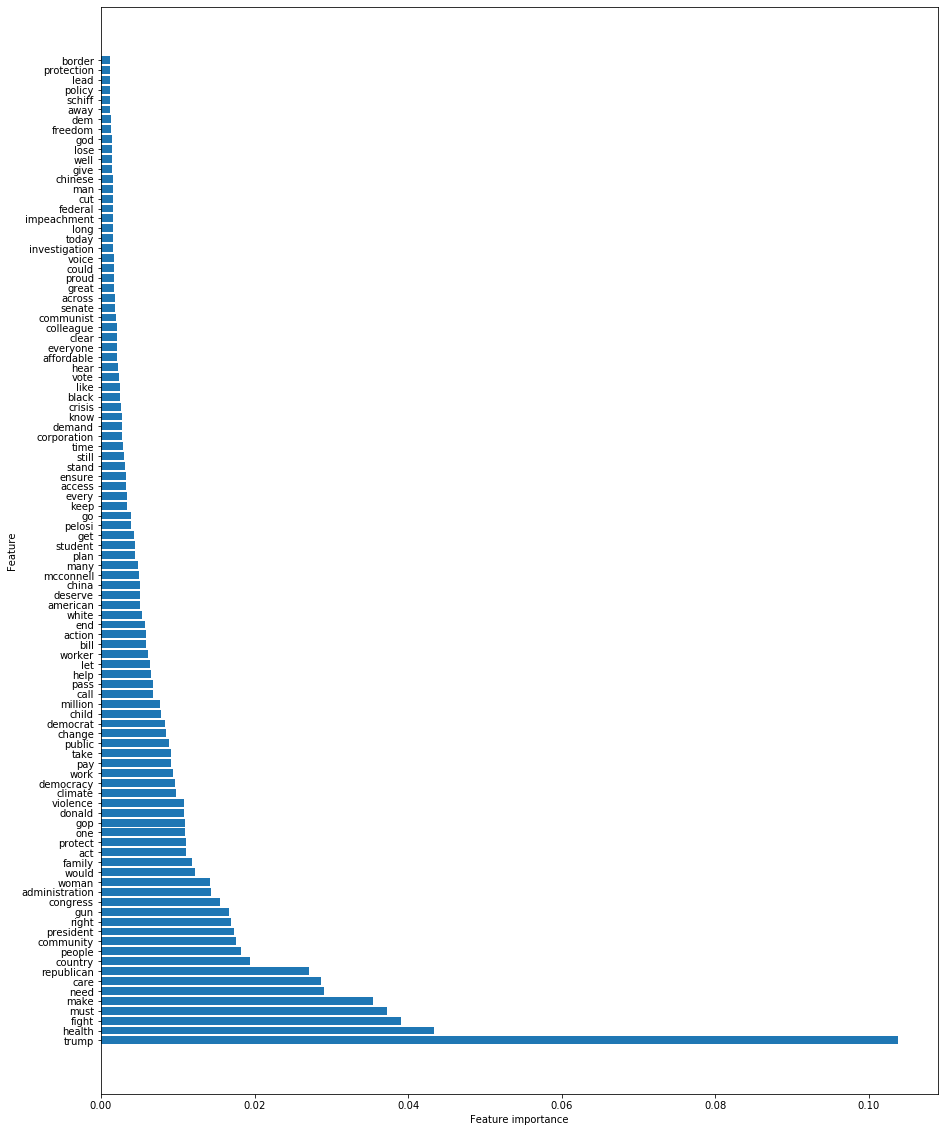

In [119]:
plot_feature_importances(pipe_rf1, 100)

The random forest classifier performed with less accuracy than logistic regression. However, one can identify the most important words in determining a class: 
- Trump
- Health
- Fight
- Must
- Make

In [120]:
pipe_nb1 = Pipeline([('t_proc', CountVectorizer(max_features=1000)),
                    ("sm", SMOTE(random_state=random_state)),
                    ('to_dense', DenseTransformer()),
                     ('clf', GaussianNB())])

In [121]:
return_classification_report(pipe_nb1, X_train, y_train, X_test, y_test)

Train Scores GaussianNB                             \
                           precision recall f1-score    support   
D                               0.82   0.74     0.78  212231.00   
R                               0.38   0.49     0.43   69181.00   
accuracy                        0.68   0.68     0.68       0.68   
macro avg                       0.60   0.62     0.60  281412.00   
weighted avg                    0.71   0.68     0.69  281412.00   

             Test Scores GaussianNB                             
                          precision recall f1-score    support  
D                              0.82   0.74     0.78   91216.00  
R                              0.38   0.49     0.42   29390.00  
accuracy                       0.68   0.68     0.68       0.68  
macro avg                      0.60   0.61     0.60  120606.00  
weighted avg                   0.71   0.68     0.69  120606.00

Naive Bayes performed similarly to Random Forest in terms of accuracy and F1 score.

##### TF-IDF

In [122]:
pipe_lr3 = Pipeline([('t_proc', TfidfVectorizer(max_features=1000)),
                     ("sm", SMOTE(random_state=random_state)),
                     ('clf', LogisticRegression())])

In [123]:
return_classification_report(pipe_lr3, X_train, y_train, X_test, y_test)

Train Scores LogisticRegression                             \
                                   precision recall f1-score    support   
D                                       0.87   0.79     0.83  212231.00   
R                                       0.50   0.65     0.56   69181.00   
accuracy                                0.75   0.75     0.75       0.75   
macro avg                               0.69   0.72     0.70  281412.00   
weighted avg                            0.78   0.75     0.76  281412.00   

             Test Scores LogisticRegression                             
                                  precision recall f1-score    support  
D                                      0.87   0.79     0.83   91216.00  
R                                      0.49   0.64     0.55   29390.00  
accuracy                               0.75   0.75     0.75       0.75  
macro avg                              0.68   0.71     0.69  120606.00  
weighted avg                           0.78   0.75     0.76  120606.00

The TF-IDF vectorizer performed slightly better than the Count Vectorizer when using Logistic Regression.

In [124]:
pipe_rf2 = Pipeline([('t_proc',  TfidfVectorizer(max_features=1000)),
                    ("sm", SMOTE(random_state=random_state)),
                     ('to_dense', DenseTransformer()),
                     ('clf', RandomForestClassifier(max_depth=20))])

In [125]:
return_classification_report(pipe_rf2, X_train, y_train, X_test, y_test)

Train Scores RandomForestClassifier(max_depth=20                  \
                                                    precision recall f1-score   
D                                                        0.87   0.71     0.78   
R                                                        0.43   0.68     0.53   
accuracy                                                 0.70   0.70     0.70   
macro avg                                                0.65   0.69     0.65   
weighted avg                                             0.76   0.70     0.72   

                       Test Scores RandomForestClassifier(max_depth=20         \
               support                                       precision recall   
D             212231.0                                            0.86   0.70   
R              69181.0                                            0.41   0.64   
accuracy           0.7                                            0.68   0.68   
macro avg     281412.0                                            0.63   0.67   
weighted avg  281412.0                                            0.75   0.68   

                                  
             f1-score    support  
D                0.77   91216.00  
R                0.50   29390.00  
accuracy         0.68       0.68  
macro avg        0.63  120606.00  
weighted avg     0.70  120606.00

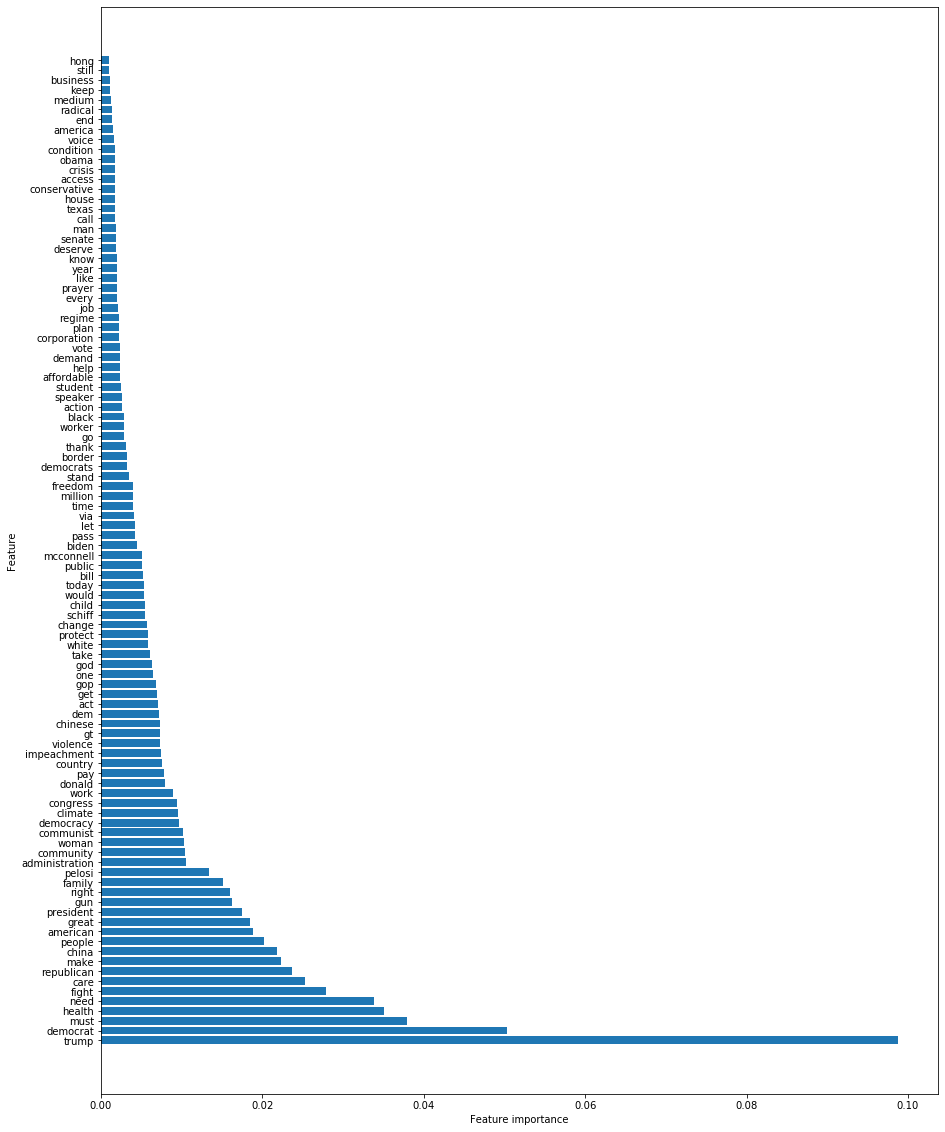

In [126]:
plot_feature_importances(pipe_rf2, 100)

There are slight differences between the feature importances with Count Vectorizer vs TF-IDF. For example, the word democrat was more important when determining a class after using the TF-IDF vectorizer.

In [127]:
pipe_nb2 = Pipeline([('t_proc', TfidfVectorizer(max_features=1000)),
                    ("sm", SMOTE(random_state=random_state)),
                    ('to_dense', DenseTransformer()),
                     ('clf', GaussianNB())])

In [128]:
return_classification_report(pipe_nb2, X_train, y_train, X_test, y_test)

Train Scores GaussianNB                             \
                           precision recall f1-score    support   
D                               0.86   0.73     0.79  212231.00   
R                               0.43   0.64     0.52   69181.00   
accuracy                        0.71   0.71     0.71       0.71   
macro avg                       0.65   0.68     0.65  281412.00   
weighted avg                    0.76   0.71     0.72  281412.00   

             Test Scores GaussianNB                             
                          precision recall f1-score    support  
D                              0.86   0.73     0.79   91216.00  
R                              0.43   0.63     0.51   29390.00  
accuracy                       0.71   0.71     0.71       0.71  
macro avg                      0.65   0.68     0.65  120606.00  
weighted avg                   0.76   0.71     0.72  120606.00

Naive Bayes performed similarly to random forest classifier in terms of accuracy. 

### Neural Network Modeling

We will now perform text classification using a Neural Network. Within the neural network, we will use a text processing technique called Word Embeddings. Word embeddings are a learned numerical representation for words in the form of a vector. Words that are "close" to other words in the vector space are considered more similar, which allows the model to detect and interpret semantic relationships. We will use a pretrained word embeddings document from the Stanford NLP Group. 

We will use the Keras library to vectorize our text and build our model.

In [56]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation, GRU, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.initializers import Constant
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping
import talos
import os

In [15]:
embed_dim = 300

Reading in the pretrained vector representations of words from the Standford NLP Group, and creating a dictionary with the words and their corresponding embedding.

In [16]:
embeddings_index = {}
f = open(os.path.join('', 'Data/glove.6B.300d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

We will now create a vocabulary index based on word frequency with the tokenizer object, and calculate some parameters to be used in our embedding matrix.

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) 

max_len = max([len(t.split(" ")) for t in X_train])
mean_len = round(np.mean([len(t.split(" ")) for t in X_train]))
total_vocab = len(tokenizer.word_index) + 1

Transforming each text into a sequence of integers based on the internal vocabulary index previously created (each word mapped to an integer). We will then pad each sequence to the same length (in this case the mean length of a tweet in the training data).

In [25]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_tokens, maxlen=mean_len, padding="post")
X_test_pad = pad_sequences(X_test_tokens, maxlen=mean_len, padding="post")

Mapping the word embeddings from the pretrained model stored in the embeddings index to the indicies stored in the word index object to create a matrix of vectors with a length of the total vocabulary + 1 and a width as long as the word embedding dimensions (in this case a vector sized 300).

In [26]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((total_vocab, embed_dim))
for key, val in word_index.items():
    if val > total_vocab:
        continue
    embedding_vector = embeddings_index.get(key)
    if embedding_vector is not None:
        embedding_matrix[val] = embedding_vector

Turning the y train and test variables into binary numbers (1 to represent "R" class, 0 to represent "D" class)

In [27]:
NN_y_train = y_train.map(lambda x: 0 if x == "D" else 1)
NN_y_test = y_test.map(lambda x: 0 if x == "D" else 1)

We will now assemble the model and define the embedding layer as the embedding matrix we previously created and set trainable to False, so that the model does not learn from the training data but instead uses the predefined weights passed in the embedding matrix.

In [28]:
model = Sequential()

embedding_layer = Embedding(total_vocab,
                           embed_dim,
                           embeddings_initializer=Constant(embedding_matrix),
                           input_length=mean_len,
                           trainable=False)
model.add(embedding_layer)
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 300)           16157700  
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                31968     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 16,189,701
Trainable params: 32,001
Non-trainable params: 16,157,700
_________________________________________________________________


Assigning class weights to deal with class imbalance and configuring early stopping

In [53]:
class_weight = {0: 1,
                1: 3}
callback = EarlyStopping(monitor='loss', patience=5)

In [30]:
history = model.fit(X_train_pad, NN_y_train, 
                   batch_size=100,
                   epochs=32,
                   verbose=2,
                    class_weight=class_weight,
                    callbacks = [callback], 
                   validation_data=(X_test_pad, NN_y_test))

Train on 281412 samples, validate on 120606 samples
Epoch 1/32
 - 96s - loss: 0.8704 - accuracy: 0.6807 - val_loss: 0.5907 - val_accuracy: 0.7094
Epoch 2/32
 - 84s - loss: 0.7889 - accuracy: 0.7304 - val_loss: 0.5707 - val_accuracy: 0.7362
Epoch 3/32
 - 47s - loss: 0.7633 - accuracy: 0.7424 - val_loss: 0.5635 - val_accuracy: 0.7419
Epoch 4/32
 - 43s - loss: 0.7486 - accuracy: 0.7494 - val_loss: 0.5669 - val_accuracy: 0.7312
Epoch 5/32
 - 43s - loss: 0.7379 - accuracy: 0.7547 - val_loss: 0.5628 - val_accuracy: 0.7211
Epoch 6/32
 - 43s - loss: 0.7314 - accuracy: 0.7572 - val_loss: 0.5513 - val_accuracy: 0.7443
Epoch 7/32
 - 43s - loss: 0.7281 - accuracy: 0.7579 - val_loss: 0.5341 - val_accuracy: 0.7805
Epoch 8/32
 - 43s - loss: 0.7232 - accuracy: 0.7624 - val_loss: 0.5618 - val_accuracy: 0.7274
Epoch 9/32
 - 43s - loss: 0.7201 - accuracy: 0.7614 - val_loss: 0.5623 - val_accuracy: 0.7319
Epoch 10/32
 - 43s - loss: 0.7173 - accuracy: 0.7638 - val_loss: 0.5593 - val_accuracy: 0.7189
Epoch 1

In [33]:
return_classification_report_NN(model, X_train_pad, NN_y_train, X_test_pad, NN_y_test)

Train Scores Neural Network                             \
                               precision recall f1-score    support   
0                                   0.92   0.75     0.83  212231.00   
1                                   0.51   0.79     0.62   69181.00   
accuracy                            0.76   0.76     0.76       0.76   
macro avg                           0.71   0.77     0.72  281412.00   
weighted avg                        0.82   0.76     0.78  281412.00   

             Test Scores Neural Network                             
                              precision recall f1-score    support  
0                                  0.90   0.74     0.81   91216.00  
1                                  0.48   0.76     0.59   29390.00  
accuracy                           0.74   0.74     0.74       0.74  
macro avg                          0.69   0.75     0.70  120606.00  
weighted avg                       0.80   0.74     0.76  120606.00

The model performed with an average accuracy of 74% and a f1 score of 0.7.

We will now tune the model using Talos, which acts as a kind of gridsearch to find the optimal parameters.

In [60]:
def NN_model(X_train, y_train, X_test, y_test, params):
    model = Sequential()
    embedding_layer = Embedding(total_vocab,
                           embed_dim,
                           embeddings_initializer=Constant(embedding_matrix),
                           input_length=mean_len,
                           trainable=False)
    model.add(embedding_layer)
    model.add(params["layers"](units=32, dropout= params["dropout"], recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = params["losses"], optimizer = params["optimizers"], metrics=['accuracy'])
    history = model.fit(X_train, y_train, 
                   batch_size=100,
                   epochs=8,
                   verbose=2,
                    class_weight= class_weight,
                    callbacks = [callback], 
                   validation_data=(X_test, y_test))
    
    return history, model

In [61]:
p = {"optimizers": ["Nadam", "Adam"],
    "losses": ["binary_crossentropy", "logcosh"],
     "layers": [GRU, LSTM],
    "dropout": [0.2, 0.5]}

In [62]:
t = talos.Scan(x=X_train_pad, y=NN_y_train,
           model=NN_model, 
           experiment_name = 'NN_gs',
           params=p,
            x_val = X_test_pad,
            y_val = NN_y_test)

  0%|          | 0/16 [00:00<?, ?it/s]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 48s - loss: 0.8522 - accuracy: 0.6942 - val_loss: 0.6084 - val_accuracy: 0.6702
Epoch 2/8
 - 53s - loss: 0.7838 - accuracy: 0.7343 - val_loss: 0.5911 - val_accuracy: 0.6890
Epoch 3/8
 - 52s - loss: 0.7636 - accuracy: 0.7435 - val_loss: 0.5768 - val_accuracy: 0.7089
Epoch 4/8
 - 50s - loss: 0.7531 - accuracy: 0.7473 - val_loss: 0.5831 - val_accuracy: 0.6940
Epoch 5/8
 - 51s - loss: 0.7458 - accuracy: 0.7499 - val_loss: 0.5719 - val_accuracy: 0.7179
Epoch 6/8
 - 53s - loss: 0.7401 - accuracy: 0.7540 - val_loss: 0.5600 - val_accuracy: 0.7337
Epoch 7/8
 - 51s - loss: 0.7371 - accuracy: 0.7542 - val_loss: 0.5786 - val_accuracy: 0.6852
Epoch 8/8
 - 52s - loss: 0.7313 - accuracy: 0.7576 - val_loss: 0.5468 - val_accuracy: 0.7355


  6%|▋         | 1/16 [06:59<1:44:48, 419.27s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 57s - loss: 0.8667 - accuracy: 0.6826 - val_loss: 0.5807 - val_accuracy: 0.7315
Epoch 2/8
 - 52s - loss: 0.7850 - accuracy: 0.7330 - val_loss: 0.5801 - val_accuracy: 0.7306
Epoch 3/8
 - 56s - loss: 0.7606 - accuracy: 0.7433 - val_loss: 0.5599 - val_accuracy: 0.7450
Epoch 4/8
 - 57s - loss: 0.7463 - accuracy: 0.7496 - val_loss: 0.5646 - val_accuracy: 0.7355
Epoch 5/8
 - 54s - loss: 0.7357 - accuracy: 0.7546 - val_loss: 0.5584 - val_accuracy: 0.7421
Epoch 6/8
 - 53s - loss: 0.7296 - accuracy: 0.7582 - val_loss: 0.5629 - val_accuracy: 0.7211
Epoch 7/8
 - 54s - loss: 0.7241 - accuracy: 0.7604 - val_loss: 0.5670 - val_accuracy: 0.7187
Epoch 8/8
 - 66s - loss: 0.7199 - accuracy: 0.7612 - val_loss: 0.5289 - val_accuracy: 0.7677


 12%|█▎        | 2/16 [14:37<1:43:08, 442.02s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 62s - loss: 0.1371 - accuracy: 0.6987 - val_loss: 0.0943 - val_accuracy: 0.7036
Epoch 2/8
 - 56s - loss: 0.1238 - accuracy: 0.7345 - val_loss: 0.0972 - val_accuracy: 0.6796
Epoch 3/8
 - 58s - loss: 0.1200 - accuracy: 0.7451 - val_loss: 0.0932 - val_accuracy: 0.7203
Epoch 4/8
 - 61s - loss: 0.1181 - accuracy: 0.7505 - val_loss: 0.0927 - val_accuracy: 0.7067
Epoch 5/8
 - 57s - loss: 0.1167 - accuracy: 0.7535 - val_loss: 0.0901 - val_accuracy: 0.7229
Epoch 6/8
 - 58s - loss: 0.1156 - accuracy: 0.7562 - val_loss: 0.0850 - val_accuracy: 0.7594
Epoch 7/8
 - 64s - loss: 0.1150 - accuracy: 0.7568 - val_loss: 0.0853 - val_accuracy: 0.7556
Epoch 8/8
 - 54s - loss: 0.1144 - accuracy: 0.7582 - val_loss: 0.0844 - val_accuracy: 0.7624


 19%|█▉        | 3/16 [22:36<1:39:24, 458.83s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 55s - loss: 0.1411 - accuracy: 0.6845 - val_loss: 0.1001 - val_accuracy: 0.6712
Epoch 2/8
 - 57s - loss: 0.1253 - accuracy: 0.7307 - val_loss: 0.0921 - val_accuracy: 0.7326
Epoch 3/8
 - 57s - loss: 0.1203 - accuracy: 0.7432 - val_loss: 0.0884 - val_accuracy: 0.7389
Epoch 4/8
 - 54s - loss: 0.1174 - accuracy: 0.7503 - val_loss: 0.0911 - val_accuracy: 0.7171
Epoch 5/8
 - 55s - loss: 0.1156 - accuracy: 0.7539 - val_loss: 0.0903 - val_accuracy: 0.7290
Epoch 6/8
 - 57s - loss: 0.1139 - accuracy: 0.7595 - val_loss: 0.0872 - val_accuracy: 0.7461
Epoch 7/8
 - 59s - loss: 0.1130 - accuracy: 0.7614 - val_loss: 0.0888 - val_accuracy: 0.7301
Epoch 8/8
 - 55s - loss: 0.1127 - accuracy: 0.7628 - val_loss: 0.0880 - val_accuracy: 0.7363


 25%|██▌       | 4/16 [30:15<1:31:46, 458.90s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 59s - loss: 0.8117 - accuracy: 0.7134 - val_loss: 0.4873 - val_accuracy: 0.7563
Epoch 2/8
 - 59s - loss: 0.7241 - accuracy: 0.7595 - val_loss: 0.4605 - val_accuracy: 0.7740
Epoch 3/8
 - 64s - loss: 0.6950 - accuracy: 0.7727 - val_loss: 0.4238 - val_accuracy: 0.7993
Epoch 4/8
 - 58s - loss: 0.6780 - accuracy: 0.7793 - val_loss: 0.4355 - val_accuracy: 0.7883
Epoch 5/8
 - 60s - loss: 0.6677 - accuracy: 0.7827 - val_loss: 0.4426 - val_accuracy: 0.7831
Epoch 6/8
 - 60s - loss: 0.6585 - accuracy: 0.7864 - val_loss: 0.4345 - val_accuracy: 0.7907
Epoch 7/8
 - 58s - loss: 0.6545 - accuracy: 0.7882 - val_loss: 0.4448 - val_accuracy: 0.7844
Epoch 8/8
 - 60s - loss: 0.6481 - accuracy: 0.7903 - val_loss: 0.4343 - val_accuracy: 0.7900


 31%|███▏      | 5/16 [38:21<1:25:59, 469.00s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 54s - loss: 0.8372 - accuracy: 0.6998 - val_loss: 0.4628 - val_accuracy: 0.7747
Epoch 2/8
 - 56s - loss: 0.7422 - accuracy: 0.7514 - val_loss: 0.4619 - val_accuracy: 0.7735
Epoch 3/8
 - 53s - loss: 0.7091 - accuracy: 0.7661 - val_loss: 0.4449 - val_accuracy: 0.7823
Epoch 4/8
 - 54s - loss: 0.6900 - accuracy: 0.7733 - val_loss: 0.4405 - val_accuracy: 0.7841
Epoch 5/8
 - 56s - loss: 0.6758 - accuracy: 0.7790 - val_loss: 0.4424 - val_accuracy: 0.7850
Epoch 6/8
 - 59s - loss: 0.6649 - accuracy: 0.7829 - val_loss: 0.4211 - val_accuracy: 0.7982
Epoch 7/8
 - 59s - loss: 0.6568 - accuracy: 0.7860 - val_loss: 0.4212 - val_accuracy: 0.7991
Epoch 8/8
 - 62s - loss: 0.6478 - accuracy: 0.7906 - val_loss: 0.4234 - val_accuracy: 0.7980


 38%|███▊      | 6/16 [46:03<1:17:46, 466.61s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 64s - loss: 0.1299 - accuracy: 0.7147 - val_loss: 0.0740 - val_accuracy: 0.7631
Epoch 2/8
 - 59s - loss: 0.1130 - accuracy: 0.7588 - val_loss: 0.0669 - val_accuracy: 0.7888
Epoch 3/8
 - 59s - loss: 0.1080 - accuracy: 0.7715 - val_loss: 0.0705 - val_accuracy: 0.7770
Epoch 4/8
 - 64s - loss: 0.1049 - accuracy: 0.7776 - val_loss: 0.0649 - val_accuracy: 0.7962
Epoch 5/8
 - 64s - loss: 0.1028 - accuracy: 0.7837 - val_loss: 0.0625 - val_accuracy: 0.8062
Epoch 6/8
 - 56s - loss: 0.1016 - accuracy: 0.7859 - val_loss: 0.0657 - val_accuracy: 0.7934
Epoch 7/8
 - 59s - loss: 0.1005 - accuracy: 0.7885 - val_loss: 0.0664 - val_accuracy: 0.7911
Epoch 8/8
 - 65s - loss: 0.0996 - accuracy: 0.7910 - val_loss: 0.0680 - val_accuracy: 0.7857


 44%|████▍     | 7/16 [54:21<1:11:31, 476.81s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 55s - loss: 0.1356 - accuracy: 0.6971 - val_loss: 0.0733 - val_accuracy: 0.7687
Epoch 2/8
 - 56s - loss: 0.1170 - accuracy: 0.7497 - val_loss: 0.0729 - val_accuracy: 0.7648
Epoch 3/8
 - 142s - loss: 0.1112 - accuracy: 0.7647 - val_loss: 0.0691 - val_accuracy: 0.7809
Epoch 4/8
 - 204s - loss: 0.1075 - accuracy: 0.7734 - val_loss: 0.0696 - val_accuracy: 0.7800
Epoch 5/8
 - 202s - loss: 0.1050 - accuracy: 0.7786 - val_loss: 0.0681 - val_accuracy: 0.7853
Epoch 6/8
 - 203s - loss: 0.1033 - accuracy: 0.7828 - val_loss: 0.0682 - val_accuracy: 0.7828
Epoch 7/8
 - 194s - loss: 0.1018 - accuracy: 0.7854 - val_loss: 0.0646 - val_accuracy: 0.7974
Epoch 8/8
 - 207s - loss: 0.1006 - accuracy: 0.7884 - val_loss: 0.0649 - val_accuracy: 0.7969


 50%|█████     | 8/16 [1:15:49<1:37:59, 734.96s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 165s - loss: 0.9156 - accuracy: 0.6509 - val_loss: 0.6143 - val_accuracy: 0.6741
Epoch 2/8
 - 171s - loss: 0.8601 - accuracy: 0.6914 - val_loss: 0.6220 - val_accuracy: 0.6446
Epoch 3/8
 - 202s - loss: 0.8441 - accuracy: 0.7007 - val_loss: 0.5847 - val_accuracy: 0.6967
Epoch 4/8
 - 178s - loss: 0.8377 - accuracy: 0.7063 - val_loss: 0.5815 - val_accuracy: 0.7072
Epoch 5/8
 - 193s - loss: 0.8325 - accuracy: 0.7083 - val_loss: 0.5758 - val_accuracy: 0.7011
Epoch 6/8
 - 200s - loss: 0.8301 - accuracy: 0.7096 - val_loss: 0.5610 - val_accuracy: 0.7220
Epoch 7/8
 - 200s - loss: 0.8255 - accuracy: 0.7111 - val_loss: 0.5711 - val_accuracy: 0.7111
Epoch 8/8
 - 201s - loss: 0.8230 - accuracy: 0.7136 - val_loss: 0.6102 - val_accuracy: 0.6335


 56%|█████▋    | 9/16 [1:41:28<1:55:03, 986.27s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 189s - loss: 0.9264 - accuracy: 0.6402 - val_loss: 0.5856 - val_accuracy: 0.7216
Epoch 2/8
 - 194s - loss: 0.8592 - accuracy: 0.6912 - val_loss: 0.5836 - val_accuracy: 0.7219
Epoch 3/8
 - 166s - loss: 0.8391 - accuracy: 0.7031 - val_loss: 0.5787 - val_accuracy: 0.7244
Epoch 4/8
 - 201s - loss: 0.8274 - accuracy: 0.7105 - val_loss: 0.5593 - val_accuracy: 0.7414
Epoch 5/8
 - 164s - loss: 0.8180 - accuracy: 0.7136 - val_loss: 0.5721 - val_accuracy: 0.7238
Epoch 6/8
 - 190s - loss: 0.8115 - accuracy: 0.7177 - val_loss: 0.5635 - val_accuracy: 0.7252
Epoch 7/8
 - 201s - loss: 0.8074 - accuracy: 0.7200 - val_loss: 0.5631 - val_accuracy: 0.7356
Epoch 8/8
 - 195s - loss: 0.8048 - accuracy: 0.7209 - val_loss: 0.5780 - val_accuracy: 0.7065


 62%|██████▎   | 10/16 [2:06:56<1:55:22, 1153.68s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 192s - loss: 0.1499 - accuracy: 0.6545 - val_loss: 0.0978 - val_accuracy: 0.6979
Epoch 2/8
 - 162s - loss: 0.1384 - accuracy: 0.6960 - val_loss: 0.0914 - val_accuracy: 0.7283
Epoch 3/8
 - 203s - loss: 0.1357 - accuracy: 0.7030 - val_loss: 0.0860 - val_accuracy: 0.7520
Epoch 4/8
 - 200s - loss: 0.1342 - accuracy: 0.7101 - val_loss: 0.0943 - val_accuracy: 0.7029
Epoch 5/8
 - 202s - loss: 0.1331 - accuracy: 0.7112 - val_loss: 0.0904 - val_accuracy: 0.7228
Epoch 6/8
 - 202s - loss: 0.1330 - accuracy: 0.7117 - val_loss: 0.0896 - val_accuracy: 0.7367
Epoch 7/8
 - 186s - loss: 0.1321 - accuracy: 0.7133 - val_loss: 0.0884 - val_accuracy: 0.7392
Epoch 8/8
 - 173s - loss: 0.1318 - accuracy: 0.7137 - val_loss: 0.0893 - val_accuracy: 0.7343


 69%|██████▉   | 11/16 [2:32:43<1:46:10, 1274.10s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 138s - loss: 0.1530 - accuracy: 0.6432 - val_loss: 0.0962 - val_accuracy: 0.7178
Epoch 2/8
 - 190s - loss: 0.1393 - accuracy: 0.6944 - val_loss: 0.0947 - val_accuracy: 0.7144
Epoch 3/8
 - 163s - loss: 0.1346 - accuracy: 0.7077 - val_loss: 0.0943 - val_accuracy: 0.7160
Epoch 4/8
 - 199s - loss: 0.1320 - accuracy: 0.7130 - val_loss: 0.0950 - val_accuracy: 0.6995
Epoch 5/8
 - 200s - loss: 0.1305 - accuracy: 0.7168 - val_loss: 0.0940 - val_accuracy: 0.7004
Epoch 6/8
 - 200s - loss: 0.1295 - accuracy: 0.7200 - val_loss: 0.0938 - val_accuracy: 0.7027
Epoch 7/8
 - 139s - loss: 0.1288 - accuracy: 0.7208 - val_loss: 0.0926 - val_accuracy: 0.7079
Epoch 8/8
 - 201s - loss: 0.1286 - accuracy: 0.7227 - val_loss: 0.0915 - val_accuracy: 0.7235


 75%|███████▌  | 12/16 [2:57:03<1:28:42, 1330.50s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 206s - loss: 0.8727 - accuracy: 0.6787 - val_loss: 0.4789 - val_accuracy: 0.7704
Epoch 2/8
 - 218s - loss: 0.7966 - accuracy: 0.7241 - val_loss: 0.4547 - val_accuracy: 0.7810
Epoch 3/8
 - 218s - loss: 0.7765 - accuracy: 0.7344 - val_loss: 0.4554 - val_accuracy: 0.7756
Epoch 4/8
 - 218s - loss: 0.7639 - accuracy: 0.7394 - val_loss: 0.4610 - val_accuracy: 0.7672
Epoch 5/8
 - 218s - loss: 0.7581 - accuracy: 0.7424 - val_loss: 0.4286 - val_accuracy: 0.7973
Epoch 6/8
 - 217s - loss: 0.7523 - accuracy: 0.7457 - val_loss: 0.4549 - val_accuracy: 0.7753
Epoch 7/8
 - 217s - loss: 0.7467 - accuracy: 0.7477 - val_loss: 0.4472 - val_accuracy: 0.7821
Epoch 8/8
 - 214s - loss: 0.7450 - accuracy: 0.7482 - val_loss: 0.4598 - val_accuracy: 0.7710


 81%|████████▏ | 13/16 [3:26:17<1:12:56, 1458.84s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 210s - loss: 0.8952 - accuracy: 0.6642 - val_loss: 0.5016 - val_accuracy: 0.7479
Epoch 2/8
 - 208s - loss: 0.8115 - accuracy: 0.7159 - val_loss: 0.4699 - val_accuracy: 0.7714
Epoch 3/8
 - 208s - loss: 0.7854 - accuracy: 0.7286 - val_loss: 0.4725 - val_accuracy: 0.7638
Epoch 4/8
 - 206s - loss: 0.7700 - accuracy: 0.7372 - val_loss: 0.4595 - val_accuracy: 0.7739
Epoch 5/8
 - 206s - loss: 0.7600 - accuracy: 0.7418 - val_loss: 0.4441 - val_accuracy: 0.7839
Epoch 6/8
 - 209s - loss: 0.7511 - accuracy: 0.7456 - val_loss: 0.4497 - val_accuracy: 0.7780
Epoch 7/8
 - 209s - loss: 0.7481 - accuracy: 0.7469 - val_loss: 0.4322 - val_accuracy: 0.7905
Epoch 8/8
 - 208s - loss: 0.7427 - accuracy: 0.7500 - val_loss: 0.4510 - val_accuracy: 0.7783


 88%|████████▊ | 14/16 [3:54:29<50:58, 1529.23s/it]  

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 204s - loss: 0.1422 - accuracy: 0.6796 - val_loss: 0.0741 - val_accuracy: 0.7651
Epoch 2/8
 - 201s - loss: 0.1270 - accuracy: 0.7231 - val_loss: 0.0725 - val_accuracy: 0.7701
Epoch 3/8
 - 197s - loss: 0.1232 - accuracy: 0.7336 - val_loss: 0.0747 - val_accuracy: 0.7603
Epoch 4/8
 - 205s - loss: 0.1211 - accuracy: 0.7387 - val_loss: 0.0734 - val_accuracy: 0.7650
Epoch 5/8
 - 205s - loss: 0.1195 - accuracy: 0.7431 - val_loss: 0.0686 - val_accuracy: 0.7830
Epoch 6/8
 - 204s - loss: 0.1191 - accuracy: 0.7443 - val_loss: 0.0685 - val_accuracy: 0.7841
Epoch 7/8
 - 205s - loss: 0.1186 - accuracy: 0.7462 - val_loss: 0.0672 - val_accuracy: 0.7898
Epoch 8/8
 - 205s - loss: 0.1177 - accuracy: 0.7484 - val_loss: 0.0680 - val_accuracy: 0.7869


 94%|█████████▍| 15/16 [4:22:03<26:06, 1566.76s/it]

Train on 281412 samples, validate on 120606 samples
Epoch 1/8
 - 209s - loss: 0.1474 - accuracy: 0.6623 - val_loss: 0.0816 - val_accuracy: 0.7342
Epoch 2/8
 - 209s - loss: 0.1303 - accuracy: 0.7146 - val_loss: 0.0755 - val_accuracy: 0.7565
Epoch 3/8
 - 207s - loss: 0.1252 - accuracy: 0.7285 - val_loss: 0.0742 - val_accuracy: 0.7626
Epoch 4/8
 - 205s - loss: 0.1222 - accuracy: 0.7357 - val_loss: 0.0702 - val_accuracy: 0.7783
Epoch 5/8
 - 208s - loss: 0.1201 - accuracy: 0.7423 - val_loss: 0.0715 - val_accuracy: 0.7725
Epoch 6/8
 - 209s - loss: 0.1190 - accuracy: 0.7442 - val_loss: 0.0725 - val_accuracy: 0.7711
Epoch 7/8
 - 210s - loss: 0.1181 - accuracy: 0.7464 - val_loss: 0.0682 - val_accuracy: 0.7846
Epoch 8/8
 - 180s - loss: 0.1168 - accuracy: 0.7501 - val_loss: 0.0662 - val_accuracy: 0.7921


100%|██████████| 16/16 [4:49:33<00:00, 1085.82s/it]


In [63]:
t.data

,start,end,duration,round_epochs,val_loss,val_accuracy,loss,accuracy,dropout,layers,losses,optimizers
0,03/04/21-181420,03/04/21-182111,410.932261,8,0.546841,0.735527,0.731325,0.757569,0.2,<class 'keras.layers.recurrent.GRU'>,binary_crossentropy,Nadam
1,03/04/21-182119,03/04/21-182848,449.325450,8,0.528910,0.767731,0.719927,0.761240,0.2,<class 'keras.layers.recurrent.GRU'>,binary_crossentropy,Adam
2,03/04/21-182857,03/04/21-183648,471.481067,8,0.084352,0.762408,0.114363,0.758162,0.2,<class 'keras.layers.recurrent.GRU'>,logcosh,Nadam
3,03/04/21-183656,03/04/21-184427,451.627621,8,0.088039,0.736332,0.112655,0.762800,0.2,<class 'keras.layers.recurrent.GRU'>,logcosh,Adam
4,03/04/21-184435,03/04/21-185234,479.699069,8,0.434272,0.790044,0.648067,0.790339,0.2,<class 'keras.layers.recurrent.LSTM'>,binary_crossentropy,Nadam
5,03/04/21-185242,03/04/21-190015,453.774988,8,0.423420,0.798045,0.647812,0.790567,0.2,<class 'keras.layers.recurrent.LSTM'>,binary_crossentropy,Adam
6,03/04/21-190024,03/04/21-190834,490.631693,8,0.067981,0.785724,0.099608,0.791025,0.2,<class 'keras.layers.recurrent.LSTM'>,logcosh,Nadam
7,03/04/21-190841,03/04/21-192946,1264.597223,8,0.064888,0.796876,0.100568,0.788371,0.2,<class 'keras.layers.recurrent.LSTM'>,logcosh,Adam
8,03/04/21-193009,03/04/21-195525,1515.387301,8,0.610203,0.633493,0.823038,0.713644,0.5,<class 'keras.layers.recurrent.GRU'>,binary_crossentropy,Nadam
9,03/04/21-195548,03/04/21-202053,1505.178576,8,0.578041,0.706482,0.804763,0.720925,0.5,<class 'keras.layers.recurrent.GRU'>,binary_crossentropy,Adam


It appears that the best parameters for the model are LSTM, a dropout of 0.2, binary crossentropy loss and Adam optimizer. We will fit a new model using these parameters.

In [65]:
model2 = Sequential()

embedding_layer2 = Embedding(total_vocab,
                           embed_dim,
                           embeddings_initializer=Constant(embedding_matrix),
                           input_length=mean_len,
                           trainable=False)
model2.add(embedding_layer)
model2.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 300)           16157700  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 16,200,357
Trainable params: 42,657
Non-trainable params: 16,157,700
_________________________________________________________________


In [66]:
history2 = model2.fit(X_train_pad, NN_y_train, 
                   batch_size=100,
                   epochs=32,
                   verbose=2,
                    class_weight=class_weight,
                    callbacks = [callback], 
                   validation_data=(X_test_pad, NN_y_test))

Train on 281412 samples, validate on 120606 samples
Epoch 1/32
 - 51s - loss: 0.8359 - accuracy: 0.7013 - val_loss: 0.4746 - val_accuracy: 0.7637
Epoch 2/32
 - 54s - loss: 0.7408 - accuracy: 0.7522 - val_loss: 0.4788 - val_accuracy: 0.7594
Epoch 3/32
 - 55s - loss: 0.7093 - accuracy: 0.7651 - val_loss: 0.4365 - val_accuracy: 0.7877
Epoch 4/32
 - 57s - loss: 0.6911 - accuracy: 0.7717 - val_loss: 0.4501 - val_accuracy: 0.7799
Epoch 5/32
 - 60s - loss: 0.6779 - accuracy: 0.7784 - val_loss: 0.4318 - val_accuracy: 0.7914
Epoch 6/32
 - 55s - loss: 0.6663 - accuracy: 0.7820 - val_loss: 0.4395 - val_accuracy: 0.7864
Epoch 7/32
 - 62s - loss: 0.6608 - accuracy: 0.7848 - val_loss: 0.4263 - val_accuracy: 0.7952
Epoch 8/32
 - 57s - loss: 0.6519 - accuracy: 0.7881 - val_loss: 0.4238 - val_accuracy: 0.7986
Epoch 9/32
 - 97s - loss: 0.6462 - accuracy: 0.7909 - val_loss: 0.4153 - val_accuracy: 0.8012
Epoch 10/32
 - 95s - loss: 0.6420 - accuracy: 0.7918 - val_loss: 0.4182 - val_accuracy: 0.7989
Epoch 1

In [67]:
return_classification_report_NN(model2, X_train_pad, NN_y_train, X_test_pad, NN_y_test)

Train Scores Neural Network                             \
                               precision recall f1-score    support   
0                                   0.95   0.82     0.88  212231.00   
1                                   0.61   0.86     0.72   69181.00   
accuracy                            0.83   0.83     0.83       0.83   
macro avg                           0.78   0.84     0.80  281412.00   
weighted avg                        0.87   0.83     0.84  281412.00   

             Test Scores Neural Network                            
                              precision recall f1-score   support  
0                                  0.92   0.80     0.86   91216.0  
1                                  0.56   0.79     0.65   29390.0  
accuracy                           0.80   0.80     0.80       0.8  
macro avg                          0.74   0.79     0.75  120606.0  
weighted avg                       0.83   0.80     0.81  120606.0

The model's accuracy increased to 80% and the F1 score increased as well to 0.75. This appears to be the best performing model.

### Prediction Function

We will now create a prediction function where a user can enter a tweet and the final model will return a prediction of whether the tweet could be potentially right or left biased.

In [128]:
def predict_class_NN(maximum_len=mean_len):
    test_sample = str(input("Please enter a tweet: \n"))
    proc = process_text(test_sample, pattern)
    lem = [lemmatize(proc)]
    test_tokens = tokenizer.texts_to_sequences(lem)
    test_pad = pad_sequences(test_tokens, maxlen=maximum_len)
    output = model2.predict_classes(test_pad)
    if output[0] == 1:
        return "Potentially Right Biased"
    else:
        return "Potentially Left Biased"

In [129]:
predict_class_NN()

Please enter a tweet: 
Joe Biden’s been President for 43 days. It’s only going to get worse.


'Potentially Right Biased'

In [131]:
predict_class_NN()

Please enter a tweet: 
Conservative Dems have fought so the Biden admin sends fewer & less generous relief checks than the Trump admin did.  It’s a move that makes little-to-no political or economic sense, and targets an element of relief that is most tangibly felt by everyday people. An own-goal.


'Potentially Left Biased'

### Post Modeling EDA

We will now examine some of the missclassified and correctly classified tweets.

In [181]:
def predict_probs_NN(df, maximum_len = mean_len):
    df_samp = df.sample(1000).reset_index()
    test_tokens = tokenizer.texts_to_sequences(df_samp["lemmatized"])
    test_pad = pad_sequences(test_tokens, maxlen=maximum_len)
    output_p =model2.predict(test_pad)
    p_reshape = pd.Series(output_p.reshape(output_p.shape[0], ))
    output_c = model2.predict_classes(test_pad)
    c_reshape =pd.Series(output_c.reshape(output_c.shape[0], ))
    df_new = pd.concat([df_samp["tweet"], p_reshape, c_reshape, df_samp["party"]], keys=["Tweet", "Probability", "Prediction", "Real"], axis=1)
    df_new["Prediction"] = df_new["Prediction"].map(lambda x: "R" if x == 1 else "D")
    return df_new

In [183]:
sample_preds = predict_probs_NN(preprocess)

In [231]:
print(sample_preds[sample_preds["Probability"] == sample_preds["Probability"].max()]["Tweet"].values)

['It’s a charade anyway – Democratic leader Chuck Schumer controls Nelson’s vote. Senator Nelson’s entire campaign is funded by the Democrat leaders and special interests in Washington. Schumer and Pelosi own Nelson’s vote… he doesn’t even have the option of voting with Florida.']


In [232]:
print(sample_preds[sample_preds["Probability"] == sample_preds["Probability"].min()]["Tweet"].values)

['Don’t let the NRA fool you: an overwhelming 97% of Americans support universal background checks to confront gun violence. We owe it to every victim, survivor, their families, and our communities to be stronger and louder than the gun lobby.  https://t.co/XzBXuuZ6Cd']


In [228]:
missclassified = sample_preds[sample_preds["Prediction"] != sample_preds["Real"]]

In [233]:
print(missclassified[missclassified["Probability"] == missclassified["Probability"].max()]["Tweet"].values)

['Even conservatives acknowledge that Turkey is becoming an autocracy. Erdogan is setting the country back 100 years.  https://t.co/OJyUAeeBuy']


In [234]:
print(missclassified[missclassified["Probability"] == missclassified["Probability"].min()]["Tweet"].values)

['Trump: Responsibly Restrained on Foreign Policy.  https://t.co/hjZGyTDWwa']
